In [1]:
from tira.rest_api_client import Client
import seaborn as sns
import pandas as pd

tira = Client()

In [2]:
help(tira.profiling.from_submission)

Help on method from_submission in module tira.profiling_integration:

from_submission(approach: str, dataset: str, return_pd: bool = False, allow_without_evaluation: bool = False) method of tira.profiling_integration.ProfilingIntegration instance
    Return the profiling of the run identified by the approach on the dataset, i.e.,  CPU and memory usage, but als GPU utilization if available. Will throw an exception if no profiling data is available (e.g., if profiling was not configured for the task).
    
    Entries look like [{"timestamp": 0.0, "key": "ps_cpu", "value": 0.3}, ...]. The timestamp is the time in seconds since the start of the run, the key is the name of the metric, and the value is the value of the metric. The following metrics can be available (depending on the run and the system configuration):
    
    - elapsed_time: elapsed time in seconds since the start of the run until completion of the process.
    - ps_cpu: CPU usage in percent, produced by the `ps` command.
 

In [3]:
# Some example submissions for a follow-up comparison
set_encoder_base = tira.profiling.from_submission('reneuir-2024/fschlatt/set-encoder-base', dataset='dl-top-1000-docs-20240701-training', return_pd=True)
tiny_fsu_bert = tira.profiling.from_submission('reneuir-2024/tinyfsu/tiny-fsu-bert', dataset='dl-top-1000-docs-20240701-training', return_pd=True)

set_encoder_base['approach'] = 'set-encoder-base'
tiny_fsu_bert['approach'] = 'tiny-fsu-bert'

df = pd.concat([set_encoder_base, tiny_fsu_bert])

df.sort_values('timestamp', ascending=True).head(15)

,timestamp,key,value,approach
0,0.0,ps_cpu,0.4,set-encoder-base
0,0.0,ps_cpu,0.2,tiny-fsu-bert
25,0.0,gpu_utilization,0 %,set-encoder-base
24,0.0,gpu_memory_used,4 MiB,set-encoder-base
1,0.0,ps_vsz,119820.0,tiny-fsu-bert
40,0.0,gpu_utilization,0 %,tiny-fsu-bert
39,0.0,gpu_memory_used,4 MiB,tiny-fsu-bert
2,0.0,ps_rss,239616.0,set-encoder-base
1,0.0,ps_vsz,2975140.0,set-encoder-base
2,0.0,ps_rss,85248.0,tiny-fsu-bert


In [4]:
# Simplify data for ploting

def normalize_measure_for_plotting(i):
    if i['key'] == 'gpu_utilization':
        return int(i['value'].split(' ')[0])
    if i['key'] == 'gpu_memory_used':
        return int(i['value'].split(' ')[0])
    return i['value']


df['value'] = df.apply(normalize_measure_for_plotting, axis=1)

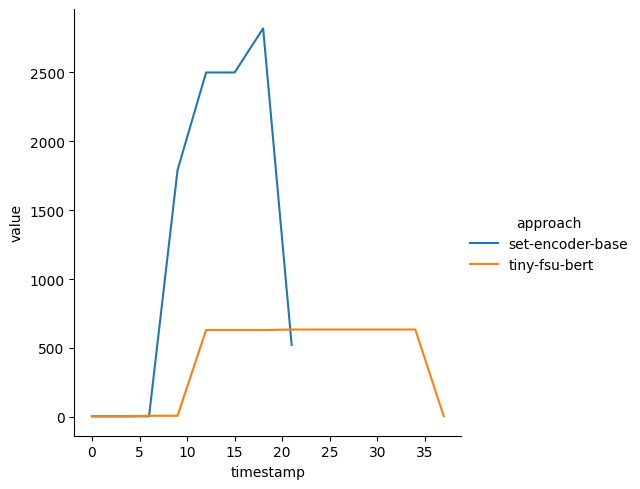

In [5]:
# gpu memory used over time
sns.relplot(x='timestamp', y='value', data=df[df['key'] == 'gpu_memory_used'], hue='approach', kind='line')

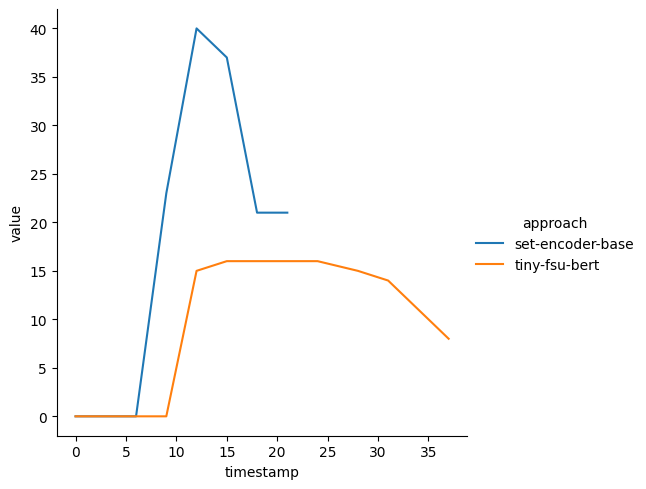

In [6]:
# gpu utilization over time
sns.relplot(x='timestamp', y='value', data=df[df['key'] == 'gpu_utilization'], hue='approach', kind='line')

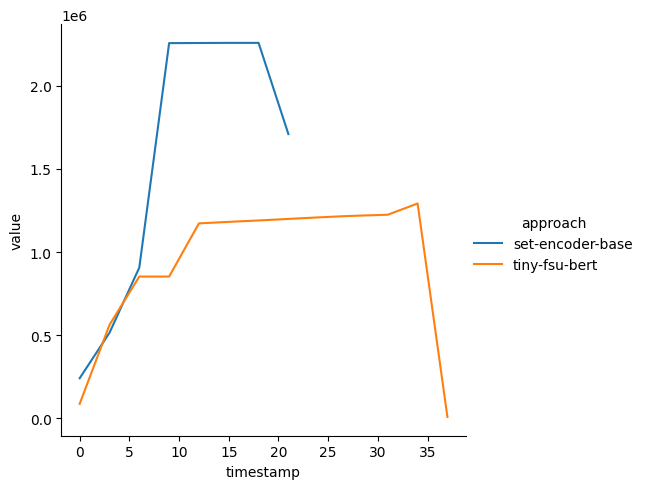

In [7]:
# RAM used over time
sns.relplot(x='timestamp', y='value', data=df[df['key'] == 'ps_rss'], hue='approach', kind='line')

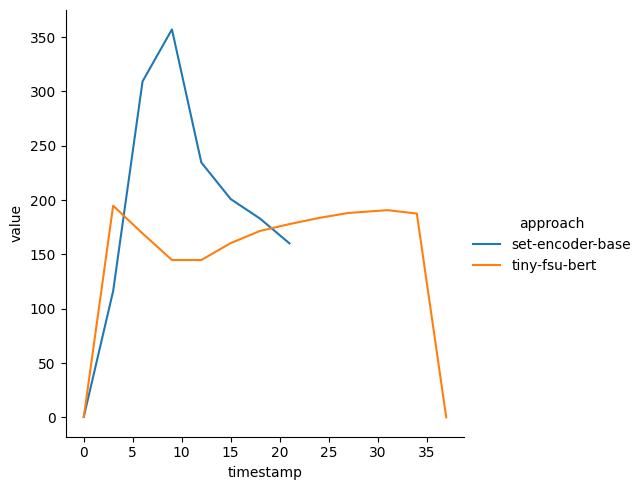

In [8]:
# CPU used over time
sns.relplot(x='timestamp', y='value', data=df[df['key'] == 'ps_cpu'], hue='approach', kind='line')

## Example on how to access raw telemetry data

In [9]:
help(tira.profiling.raw_telemetry)

Help on method raw_telemetry in module tira.profiling_integration:

raw_telemetry(approach: str, dataset: str, resource: str, allow_without_evaluation: bool = False) -> str method of tira.profiling_integration.ProfilingIntegration instance
    Return the raw telemetry "resource" of the run identified by the approach on the dataset. The passed resource specifies which telemetry to return, i.e.,
    
    - cpuinfo: The content of '/proc/cpuinfo' of the host that executed the run.
    - meminfo: The content of '/proc/meminfo' of the host that executed the run.
    - nvidia-smi.out: The content of the 'nvidia-smi' command of the host that executed the run, executed once before the software was started.
    - nvidia-smi.log: Periodic telemetry of nvidia-smi monitored while the software was executed in the sandbox.
    - ps.log: Periodic telemetry of 'ps' monitored while the software was executed in the sandbox.
    
    Args:
        approach (str): The identifier of the approach, e.g., "<t

In [13]:
nvidia_smi_log = tira.profiling.raw_telemetry(
    'reneuir-2024/tinyfsu/tiny-fsu-bert',
    dataset='dl-top-1000-docs-20240701-training',
    resource='nvidia-smi.log'
)

print(nvidia_smi_log[:5000])


==============NVSMI LOG==============

Timestamp                                 : Sun Jul  7 11:31:34 2024
Driver Version                            : 545.29.06
CUDA Version                              : 12.3

Attached GPUs                             : 1
GPU 00000000:41:00.0
    FB Memory Usage
        Total                             : 40960 MiB
        Reserved                          : 621 MiB
        Used                              : 4 MiB
        Free                              : 40333 MiB
    BAR1 Memory Usage
        Total                             : 65536 MiB
        Used                              : 1 MiB
        Free                              : 65535 MiB
    Conf Compute Protected Memory Usage
        Total                             : 0 MiB
        Used                              : 0 MiB
        Free                              : 0 MiB
    Utilization
        Gpu                               : 0 %
        Memory                            : 0 %
        

# Example on how to access job logs

In [19]:
job_execution = tira.get_run_output('reneuir-2024/fschlatt/set-encoder-base', dataset='dl-top-1000-docs-20240701-training')

print(job_execution + ':\n')
!ls -lh {job_execution}/..

/root/.tira/extracted_runs/reneuir-2024/dl-top-1000-docs-20240701-training/fschlatt/2024-07-08-13-41-16/output:

total 52K
-rw-r--r-- 1 root root  145 Jul 11 19:12 file-list.txt
drwxr-xr-x 2 root root 4.0K Jul 11 19:12 output
-rw-r--r-- 1 root root 2.3K Jul 11 19:12 parsed_profiling.jsonl
-rw-r--r-- 1 root root 6.8K Jul 11 19:12 profiling.zip
-rw-r--r-- 1 root root   63 Jul 11 19:12 run-review.bin
-rw-r--r-- 1 root root  158 Jul 11 19:12 run-review.prototext
-rw-r--r-- 1 root root  141 Jul 11 19:12 run.bin
-rw-r--r-- 1 root root  241 Jul 11 19:12 run.prototext
-rw-r--r-- 1 root root   21 Jul 11 19:12 size.txt
-rw-r--r-- 1 root root 1.3K Jul 11 19:12 stderr.txt
-rw-r--r-- 1 root root 7.6K Jul 11 19:12 stdout.txt


In [17]:
!head -10 {job_dir}/../stdout.txt

You are offline and the cache for model files in Transformers v4.22.0 has been updated while your local cache seems to be the one of a previous version. It is very likely that all your calls to any `from_pretrained()` method will fail. Remove the offline mode and enable internet connection to have your cache be updated automatically, then you can go back to offline mode.
0it [00:00, ?it/s]
/opt/conda/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py:40: No seed found, seed set to 0
Seed set to 0
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=95` in the `DataLoader` to 